<a href="https://colab.research.google.com/github/educanto/visaoComputacional/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from fastai import __version__
print(__version__)
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import cv2
import time
import numpy as np

1.0.61


In [ ]:
# Write here your working directory
root_path = '/content/gdrive/MyDrive/Visão Computacional/Trabalho'
images_path = ''

In [ ]:
# Set the working directory as a relative directory
import os
os.chdir(root_path)

## **Building dataset**

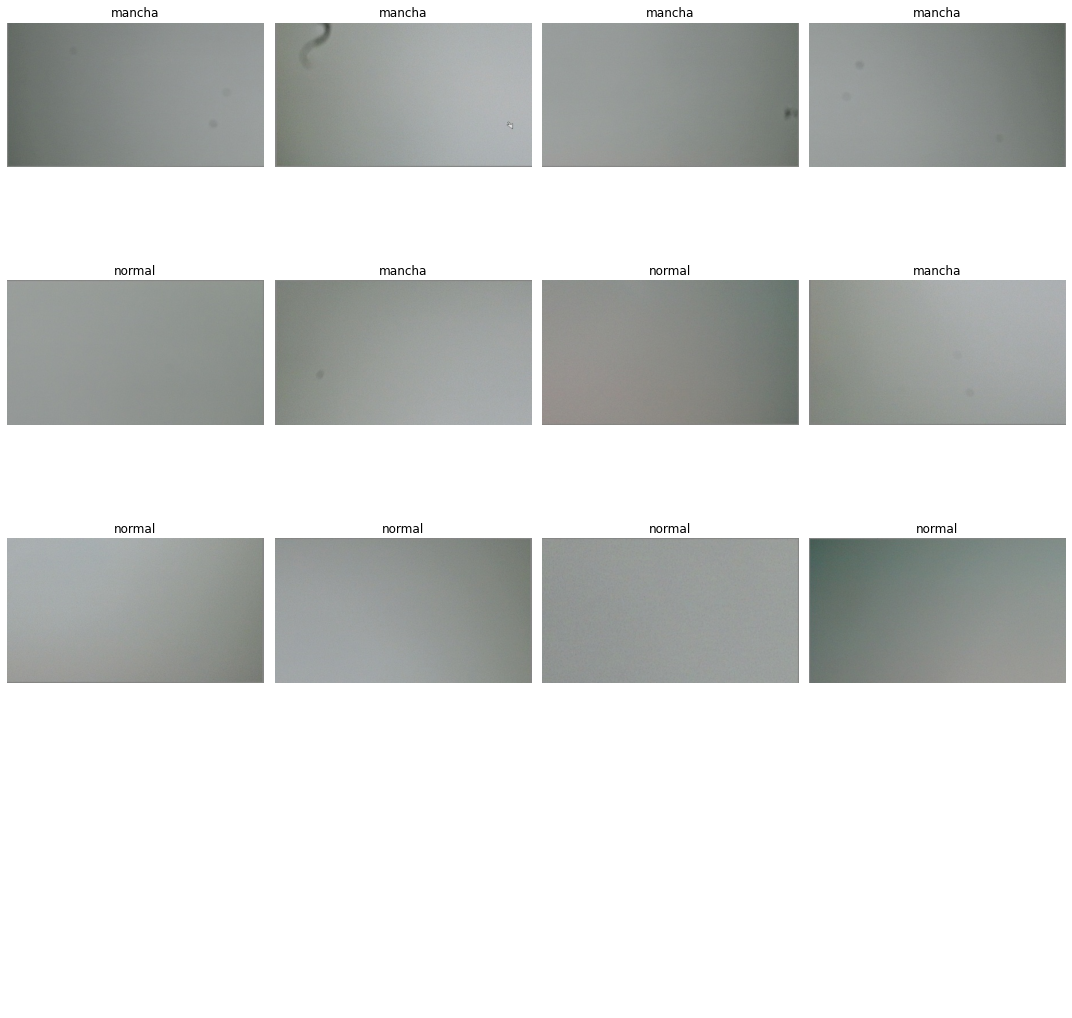

In [ ]:
data = ImageDataBunch.from_folder(path=images_path, bs = 12, valid_pct = 0.2)
data.show_batch(rows=5, figsize=(15,15))

**Show the classes**

In [ ]:
vc = pd.value_counts(data.train_ds.y.items, sort=False)     # Show the number of training set images 
vc.index = data.classes
vc

mancha    371
normal    378
dtype: int64

## **Training resnet**


**Load learner**

In [ ]:
learn18 = cnn_learner(data, models.resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

**Training**

In [ ]:
learn18.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.042357,0.496395,0.796791,02:42
1,0.933513,0.776009,0.732620,00:11
2,0.692826,0.712885,0.754011,00:10
3,0.559400,0.545678,0.802139,00:10
4,0.506518,0.453022,0.823529,00:10
5,0.453686,0.420929,0.802139,00:10
6,0.363467,0.377956,0.818182,00:10
7,0.358518,0.392122,0.855615,00:10
8,0.271716,0.345027,0.850267,00:10
9,0.256874,0.352557,0.871658,00:10


**Results**

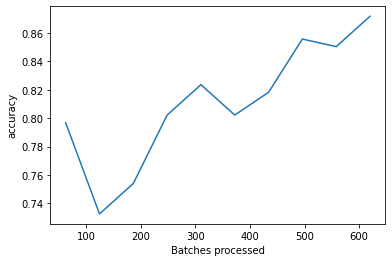

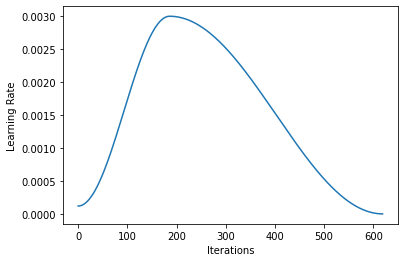

In [ ]:
learn18.recorder.plot_metrics()
learn18.recorder.plot_lr()

**Fine Tunning (if needed)**


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


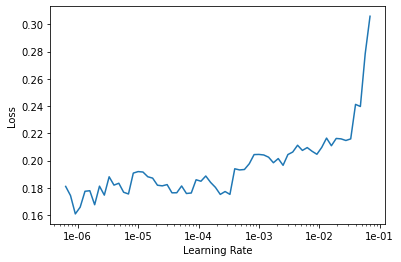

In [ ]:
# Find the best learning rate range for your application (if needed)

# learn18.lr_find()
# learn18.recorder.plot()

In [ ]:
learn18_t = deepcopy(learn18)

learn18_t.unfreeze()        # Set all layers as trainable
learn18_t.fit_one_cycle(7)

epoch,train_loss,valid_loss,accuracy,time
0,0.333149,0.576955,0.791444,00:14
1,0.380855,0.750239,0.679144,00:13
2,0.242017,0.292358,0.893048,00:13
3,0.164909,0.085308,0.983957,00:13
4,0.083726,0.092684,0.983957,00:13
5,0.060922,0.010430,0.994652,00:13
6,0.034017,0.003739,1.000000,00:13


**Final Results**

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 126, 224]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 126, 224]       128        True      
______________________________________________________________________
ReLU                 [64, 126, 224]       0          False     
______________________________________________________________________
MaxPool2d            [64, 63, 112]        0          False     
______________________________________________________________________
Conv2d               [64, 63, 112]        36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 63, 112]        128        True      
______________________________________________________________________
ReLU                 [64, 63, 112]        0          False     
___________________________________________________

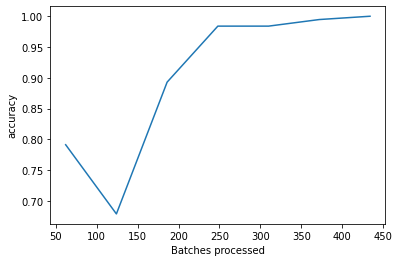

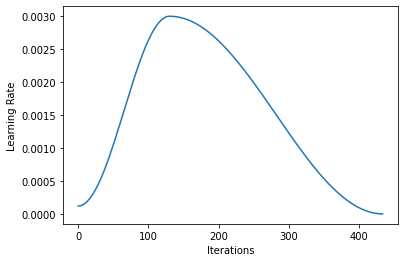

In [ ]:
learn18_t.recorder.plot_metrics()
learn18_t.recorder.plot_lr()

learn18_t.summary()

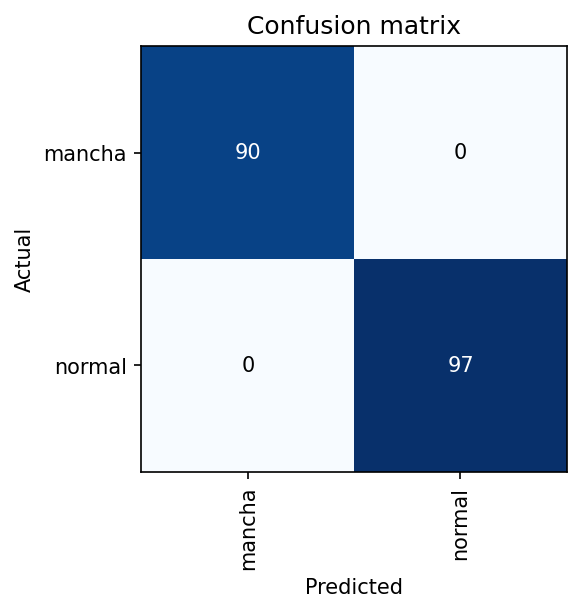

In [ ]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=150)

**Top losses**

In [ ]:
interp = ClassificationInterpretation.from_learner(learn18_t)

losses,idxs = interp.top_losses()
print(data.valid_ds.x.items[idxs])

len(data.valid_ds)==len(losses)==len(idxs)

[PosixPath('mancha/06_12_2021__12_21_21_10_f3.jpg') PosixPath('mancha/06_12_2021__12_21_21_10_f1.jpg')
 PosixPath('mancha/09_12_2021__16_04_48_00_f2.jpg') PosixPath('mancha/22_11_2021__15_01_12_11_f2.jpg') ...
 PosixPath('mancha/25_11_2021__09_10_01_01_f3.jpg') PosixPath('mancha/22_11_2021__14_53_29_00_f3.jpg')
 PosixPath('mancha/06_12_2021__12_41_08_01_f0.jpg') PosixPath('mancha/25_11_2021__09_07_17_00_f1.jpg')]


True

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward

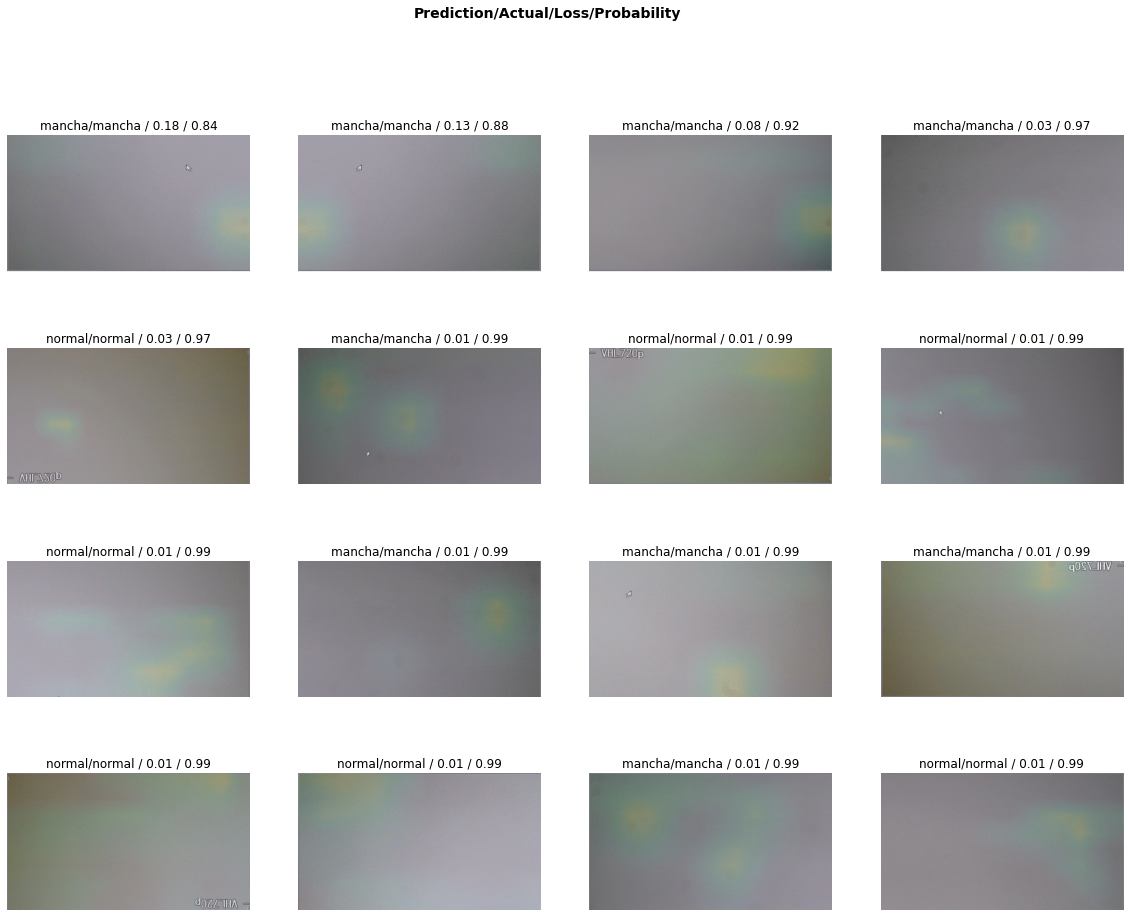

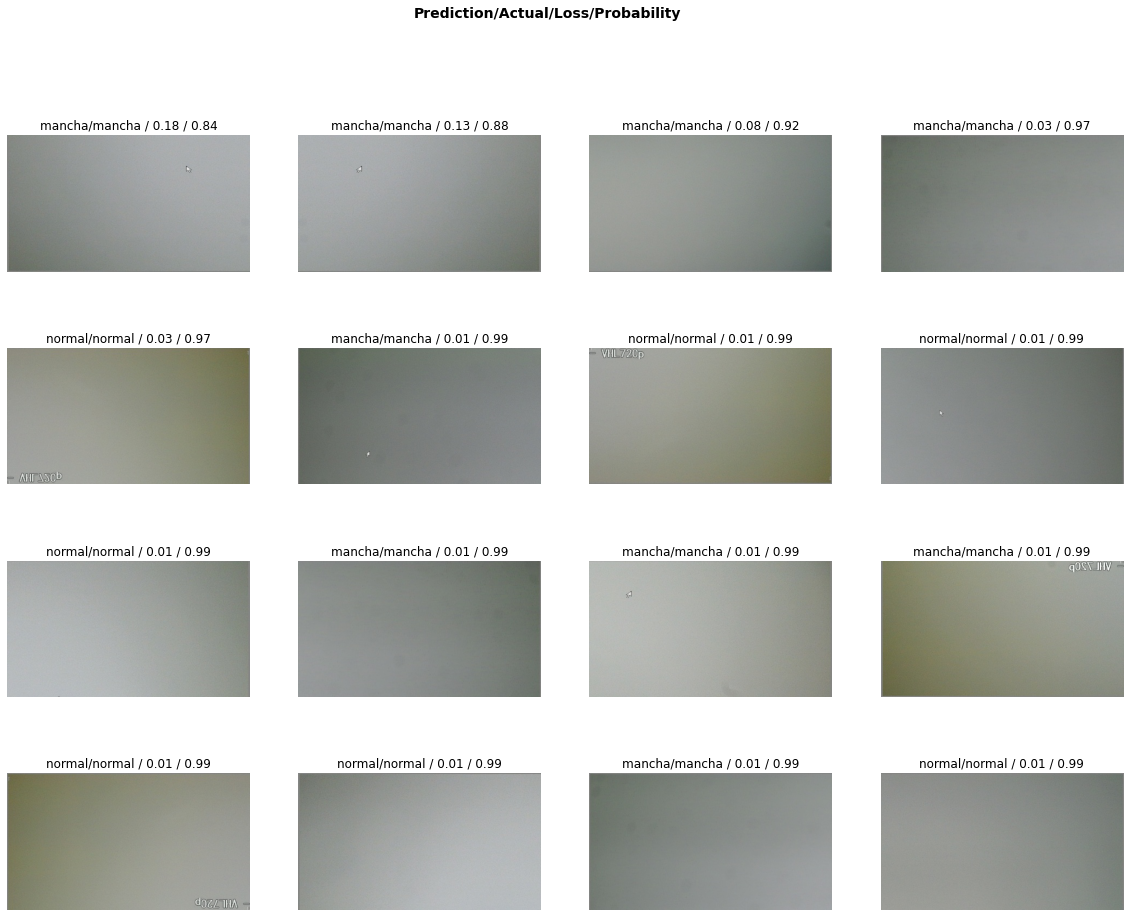

In [ ]:
interp.plot_top_losses(16, figsize=(20,15), heatmap=True, alpha=0.1,cmap='viridis')
interp.plot_top_losses(16, figsize=(20,15), heatmap=False)

### **Export model**

In [ ]:
learn18_t.export('model.pkl')

# **Model performance**

**Load model**

In [ ]:
# Write here your .pkl path

model = load_learner('', 'model.pkl')

In [ ]:
# The classification is applied to all images in the dataset

classes_folders = []
files = os.listdir(root_path)
for file in files:
    if os.path.isdir(root_path + '/' + file):
        classes_folders.append(file)

true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0

tests_time = []

for class_folder in classes_folders:
    counter = 0
    print(class_folder)
    imgs = os.listdir(root_path + '/' + class_folder)
    for img in imgs:
        if '.jpg' not in img:           # Exclude non-image files
            continue

        path = root_path + '/' + class_folder + '/' + img

        if 'mancha' in path:
            actual_result = False
        else:
            actual_result = True

        print(path)
        frame = cv2.imread(path)
        frame_tensor = Image(pil2tensor(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), np.float32).div_(255.0))

        init_time = time.time()
        preds,tensor,probs = model.predict(frame_tensor)    # Run classification process
        test_time = time.time() - init_time

        tests_time.append(test_time)

        if preds.obj == 'mancha':
            result = False
        else:
            result = True
        
        # Evaluate the results and plot some of them
        if actual_result == True and result == True:
            true_positives += 1
        elif actual_result == False and result == False:
            true_negatives += 1
        elif actual_result == False and result == True:
            false_positives += 1
            if counter < 5:
                counter += 1
                print('Predicted: normal / Actual: mancha')
                plt.figure(figsize = (6,5))
                plt.imshow(frame)
        elif actual_result == True and result == False:
            false_negatives += 1
            if counter < 5:
                counter += 1
                print('Predicted: mancha / Actual: normal')
                plt.figure(figsize = (6,5))
                plt.imshow(frame)


        print('\nTrue positives: ' + str(true_positives) +
                '\nTrue negatives: ' + str(true_negatives) +
                '\nFalse positives: ' + str(false_positives) +
                '\nFalse negatives: ' + str(false_negatives) +
                '\nAverage time: ' + str(round(1000*sum(tests_time)/len(tests_time),2)) + ' ms'
                '\nTotal time: ' + str(round(sum(tests_time),2)) + ' s')

print('\nfinished')

# Calcule the accuracy
accuracy = round(100*(true_positives+true_negatives)/(true_positives+true_negatives+false_positives+false_negatives),2)

print('\n\nAccuracy: ' + str(accuracy) + ' %' +
      '\nTotal time: ' + str(round(sum(tests_time),2)) + ' s')

A saída de streaming foi truncada nas últimas 5000 linhas.
Total time: 5.63 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/22_11_2021__16_52_54_01_f0.jpg

True positives: 313
True negatives: 0
False positives: 0
False negatives: 0
Average time: 18.03 ms
Total time: 5.64 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/22_11_2021__16_55_17_11_f0.jpg

True positives: 314
True negatives: 0
False positives: 0
False negatives: 0
Average time: 18.02 ms
Total time: 5.66 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/06_12_2021__15_31_45_01_f3.jpg

True positives: 315
True negatives: 0
False positives: 0
False negatives: 0
Average time: 18.02 ms
Total time: 5.68 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/06_12_2021__15_25_09_10_f2.jpg

True positives: 316
True negatives: 0
False positives: 0
False negatives: 0
Average time: 18.01 ms
Total time: 5.69 s
/content/gdrive/MyDrive/Visão Computacional/Trabalho/normal/22_11_2021__14_50_01_1